In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
import cv2
import os
import skimage
from tensorflow.keras.applications.vgg19 import VGG19
from skimage.segmentation import clear_border
from skimage import measure, img_as_float, io, feature
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 


Cargamos y visualizamos el dataset

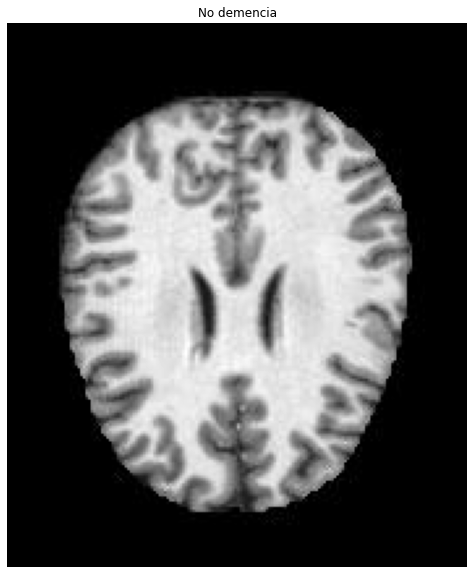

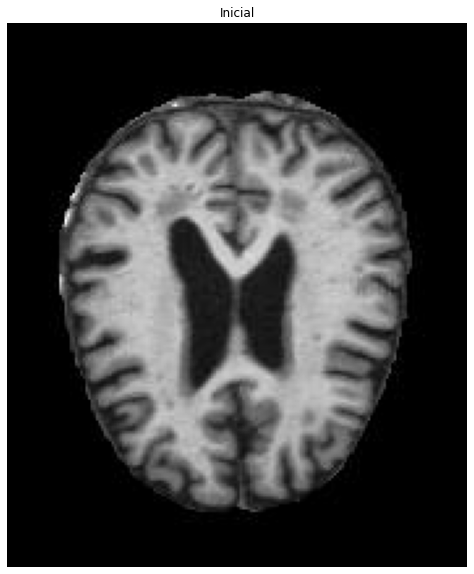

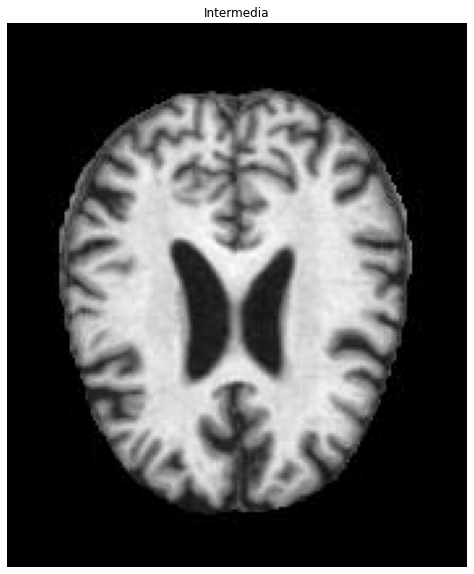

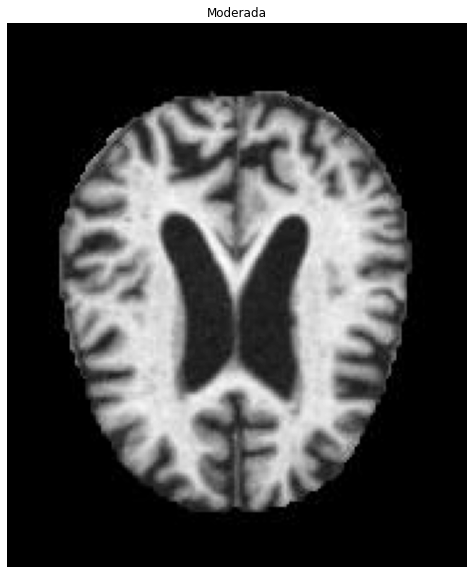

In [3]:
#No demencia
dir_nodemencia = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented'
list_nodemencia = os.listdir(dir_nodemencia)
imag_file = os.path.join(dir_nodemencia,list_nodemencia[10])
imag_nodemencia = img_as_float(io.imread(imag_file))

#Etapa inicial
dir_verymild ='../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented'
list_inicial = os.listdir(dir_verymild)
imag_file2 = os.path.join(dir_verymild, list_inicial[10])
imag_inicial = img_as_float(io.imread(imag_file2))

#Etapa intermedia
dir_mild = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented'
list_inter = os.listdir(dir_mild)
imag_file3 = os.path.join(dir_mild, list_inter[8])
imag_intermedia = img_as_float(io.imread(imag_file3))

#Demencia moderada
dir_modmild ='../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented'
list_mod = os.listdir(dir_modmild)
imag_file4 = os.path.join(dir_modmild, list_mod[8])
imag_moderada = img_as_float(io.imread(imag_file4))

imags =[imag_nodemencia, imag_inicial, imag_intermedia,imag_moderada]
labels = ['No demencia', 'Inicial', 'Intermedia','Moderada']

for idex,imag in enumerate(imags):
    plt.figure(figsize=(10,10))
    plt.imshow(imag, cmap='gray')
    plt.title(labels[idex])
    plt.axis('off')
    plt.show()
        


Aplicamos filtros para los bordes

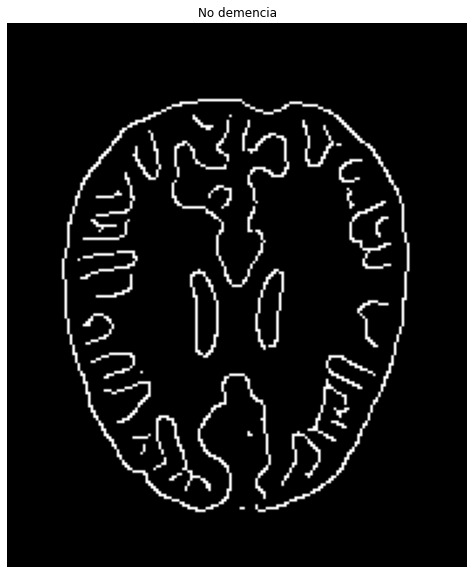

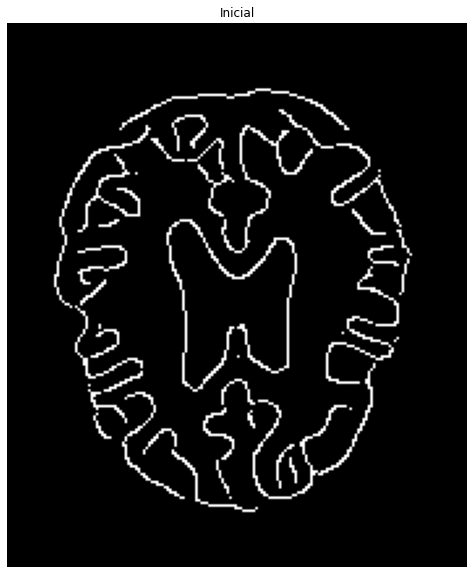

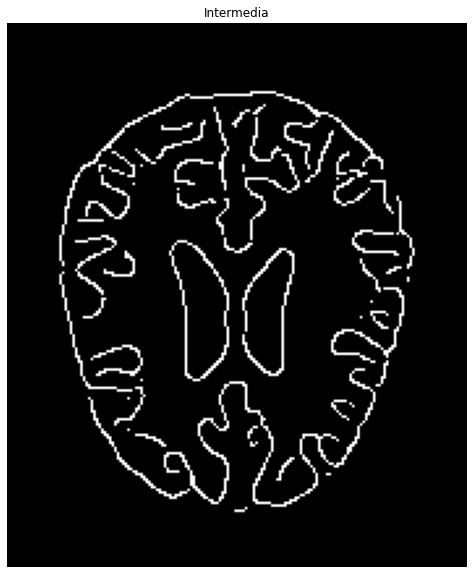

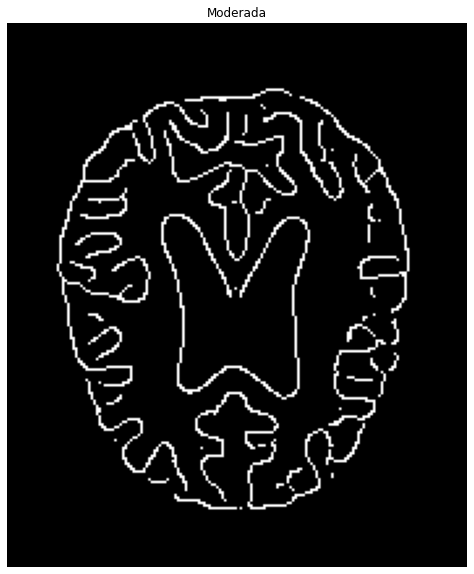

In [4]:
edges_nodemencia = feature.canny(imag_nodemencia, sigma = 3)
edges_inicial = feature.canny(imag_inicial, sigma = 3)
edges_intermedia = feature.canny(imag_intermedia, sigma=3)
edges_moderada = feature.canny(imag_moderada, sigma = 3)

edges =[edges_nodemencia, edges_inicial, edges_intermedia, edges_moderada]

for idex,imag in enumerate(edges):
    plt.figure(figsize=(10,10))
    plt.imshow(imag, cmap='gray')
    plt.title(labels[idex])
    plt.axis('off')
    plt.show()

Calculo del área

Representación de HUE para interpretar imagenes médicas

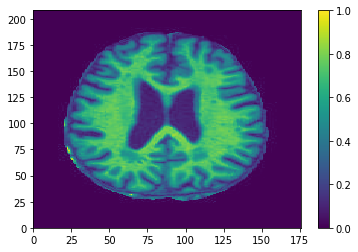

In [5]:
plt.pcolormesh(imag_inicial)
plt.colorbar()

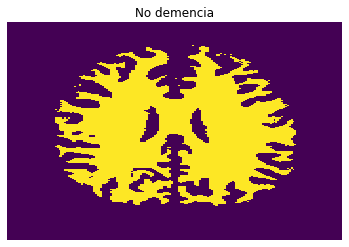

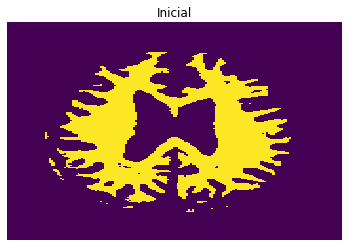

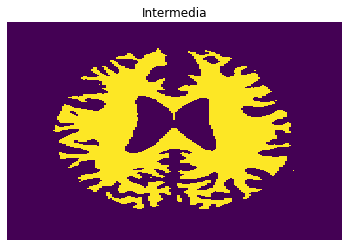

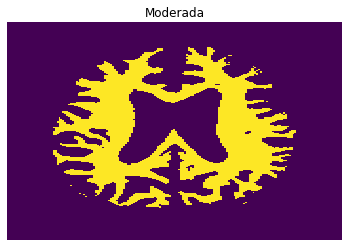

In [6]:
mask_nodemencia = imag_nodemencia >0.6
mask_inicial = imag_inicial > 0.5
mask_intermedia = imag_intermedia >0.6
mask_moderada = imag_moderada > 0.6
masks = [mask_nodemencia, mask_inicial, mask_intermedia,mask_moderada]

for idex,mask in enumerate(masks):
    mask = clear_border(mask)
    plt.pcolormesh(mask)
    plt.title(labels[idex])
    plt.axis('off')
    plt.show()

In [7]:
#masks = [mask_nodemencia, mask_inicial, mask_moderada]
masks_rps = []
areas_max = []
idxs=[]

for idex, mask in enumerate(masks):
    mask = label(mask)
    rps = regionprops(mask)
    masks_rps.append(rps)
    areas = [r.area for r in rps]
    idx = np.argsort(areas)[::-1]
    max_areas = np.max(areas)
    areas_max.append(max_areas)
    idxs.append(idx)
    
for idex,area in enumerate(areas_max):
   print("Para la imagen {}, el valor del area es:".format(labels[idex]),area)

Para la imagen No demencia, el valor del area es: 10747
Para la imagen Inicial, el valor del area es: 7752
Para la imagen Intermedia, el valor del area es: 9102
Para la imagen Moderada, el valor del area es: 7944


# Red Neuronal

In [8]:
#define image dataset 
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 target_size=(176,208), 
                                                 class_mode=None)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(input_shape = [176,208,3],filters = 64,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 64,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters = 128,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 128,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters = 256,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 256,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 256,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters = 512,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 512,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 512,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters = 512,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 512,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters = 512,kernel_size =(3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation = 'relu' ),
    keras.layers.Dense(400, activation = 'relu' ),
    keras.layers.Dense(4, activation = 'softmax')
])

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)
model.fit(train_dataset, epochs=5, validation_data=validation_dataset, callbacks=callback)

2022-11-15 17:12:36.292718: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-15 17:12:37.033694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
513/513 [==============================] - 3181s 6s/step - loss: 1.0597 - auc: 0.7772 - val_loss: 1.0358 - val_auc: 0.7804
Epoch 2/5
513/513 [==============================] - 3130s 6s/step - loss: 1.0467 - auc: 0.7793 - val_loss: 1.0380 - val_auc: 0.7804
Epoch 3/5
513/513 [==============================] - 3266s 6s/step - loss: 1.0413 - auc: 0.7783 - val_loss: 1.0488 - val_auc: 0.7804
Epoch 4/5
513/513 [==============================] - 3394s 7s/step - loss: 1.0413 - auc: 0.7796 - val_loss: 1.0349 - val_auc: 0.7804
Epoch 5/5
513/513 [==============================] - 3438s 7s/step - loss: 1.0395 - auc: 0.7792 - val_loss: 1.0424 - val_auc: 0.7804


In [10]:
#model = keras.models.Sequential([keras.layers.Flatten(input_shape = [176,208,3]),                             
#keras.layers.Dense(300, activation = 'relu' ),

#keras.layers.Dense(400, activation = 'relu' ),

#keras.layers.Dense(400, activation = 'relu' ),

#keras.layers.Dense(400, activation = 'relu' ),
#keras.layers.Dense(4, activation = 'softmax')])

#model.compile(optimizer='adam',
#loss=tensorflow.losses.CategoricalCrossentropy(),
#metrics=[keras.metrics.AUC(name='auc')])
#callback = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=3,
#                                            restore_best_weights=True)
#model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

In [11]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

128/128 [==============================] - 200s 2s/step - loss: 1.0424 - auc: 0.7804
Loss:  1.042435884475708
Accuracy:  0.7803845405578613
